# Amazon Bedrock boto3 Setup

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio*

---

In this demo notebook, we demonstrate how to use the [`boto3` Python SDK](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) to work with [Amazon Bedrock](https://aws.amazon.com/bedrock/) Foundation Models.

---

## Prerequisites

⚠️ You should already have run the [../download-dependencies.sh script](../download-dependencies.sh) to fetch the SDK packages required for using Bedrock.

Once the packages are ready, you'll need to run the below cell to install them in the notebook kernel:

In [ ]:
%pip install --no-build-isolation --force-reinstall \
    "boto3>=1.28.57" \
    "awscli>=1.29.57" \
    "botocore>=1.31.57"

This notebook demonstrates invoking Bedrock models directly using the AWS SDK, but for later notebooks in the workshop you'll also need to install [LangChain](https://github.com/hwchase17/langchain):

In [ ]:
%pip install --quiet langchain==0.0.309

---

## Create the boto3 client

Interaction with the Bedrock API is done via the AWS SDK for Python: [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html).

Depending on your environment, you might need to customize the setup when creating your Bedrock service client. To help with this, we've provided a `get_bedrock_client()` utility method that supports passing in different options. You can find the implementation in [../utils/bedrock.py](../utils/bedrock.py)

#### Use different clients
The boto3 provides different clients for Amazon Bedrock to perform different actions. The actions for [`InvokeModel`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModel.html) and [`InvokeModelWithResponseStream`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModelWithResponseStream.html) are supported by Amazon Bedrock Runtime where as other operations, such as [ListFoundationModels](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_ListFoundationModels.html), are handled via [Amazon Bedrock client](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_Operations_Amazon_Bedrock.html).

The `get_bedrock_client()` method accepts `runtime` (default=True) parameter to return either `bedrock` or `bedrock-runtime` client.

In [1]:
import json
import boto3

bedrock_boto3 = boto3.client(service_name='bedrock', region_name='us-east-1')

#### Validate the connection

We can check the client works by trying out the `list_foundation_models()` method, which will tell us all the models available for us to use 

In [2]:
bedrock_boto3.list_foundation_models()

{'ResponseMetadata': {'RequestId': '49c8cea7-9230-4de6-b5b8-d4d5cb9d76f9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 10 Oct 2023 13:25:23 GMT',
   'content-type': 'application/json',
   'content-length': '5729',
   'connection': 'keep-alive',
   'x-amzn-requestid': '49c8cea7-9230-4de6-b5b8-d4d5cb9d76f9'},
  'RetryAttempts': 0},
 'modelSummaries': [{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-tg1-large',
   'modelId': 'amazon.titan-tg1-large',
   'modelName': 'Titan Text Large',
   'providerName': 'Amazon',
   'inputModalities': ['TEXT'],
   'outputModalities': ['TEXT'],
   'responseStreamingSupported': True,
   'customizationsSupported': ['FINE_TUNING'],
   'inferenceTypesSupported': ['ON_DEMAND']},
  {'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-e1t-medium',
   'modelId': 'amazon.titan-e1t-medium',
   'modelName': 'Titan Text Embeddings',
   'providerName': 'Amazon',
   'inputModalities': ['TEXT'],
   'outputModalities'

---

## Try out the models

Let's see the models in action! Run the cells below to see basic, synchronous example invocations.

In [3]:
bedrock_runtime = boto3.client(service_name='bedrock-runtime', region_name='us-east-1')

### Anthropic Claude

In [4]:
# If you'd like to try your own prompt, edit this parameter!
prompt_data = """Human: Write me a blog about making strong business decisions as a leader.

Assistant:
"""

body = json.dumps({"prompt": prompt_data, "max_tokens_to_sample": 500})
modelId = "anthropic.claude-instant-v1"  # change this to use a different version from the model provider
accept = "application/json"
contentType = "application/json"

response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

print(response_body.get("completion"))

 Here is a draft blog post about making strong business decisions as a leader:

Making Strong Business Decisions as a Leader

As a leader, one of your most important responsibilities is making key business decisions that will help guide your company toward success. However, making the right call is not always easy - there are often many factors to consider and potential outcomes to weigh. Here are some tips for leaders to help ensure they are making strong, well-informed decisions.

Gather All Relevant Information
Before deciding on a course of action, be sure to gather as much pertinent information as possible. Talk to people from different departments who may have insights. Review past data and industry trends. Identify potential risks and opportunities. The more informed you are, the clearer picture you will have to make the best choice. 

Consult Your Team
As a leader, you don't need to go it alone. Bring your direct reports and other knowledgeable team members into the decision ma

### Cohere Command

In [5]:
prompt_data = """Write me a blog about making strong business decisions as a leader.

Blog:
"""

body = json.dumps({"prompt": prompt_data, "max_tokens":400, "temperature":0.0})
modelId = "cohere.command-text-v14"  # change this to use a different version from the model provider
accept = "application/json"
contentType = "application/json"

response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

print(response_body.get("generations")[0].get("text"))

 As a leader, one of your most important responsibilities is making strong business decisions. This can be a daunting task, as there are often many factors to consider and no guarantee of success. However, by following a few key steps, you can make more informed and effective decisions for your business.

First, it's important to gather as much information as possible. This means not only collecting data and analytics, but also seeking input from your team members and other stakeholders. By considering various perspectives, you can get a more well-rounded understanding of the situation and make a more informed decision.

Second, it's important to identify your goals and objectives. What are you hoping to achieve with this decision? What are your long-term and short-term priorities? By having a clear understanding of your goals, you can make decisions that are more aligned with your business's needs.

Third, it's important to consider the potential risks and consequences of your decisio

## Generate streaming output

For large language models, it can take noticeable time to generate long output sequences. Rather than waiting for the entire response to be available, latency-sensitive applications may like to **stream** the response to users.

Run the code below to see how you can achieve this with Bedrock's `invoke_model_with_response_stream()` method - returning the response body in separate chunks.

In [6]:
from IPython.display import clear_output, display, display_markdown, Markdown

prompt_data = """Human: Write me a blog about making strong business decisions as a leader.

Assistant:
"""

body = json.dumps({"prompt": prompt_data, "max_tokens_to_sample": 500})
modelId = "anthropic.claude-instant-v1"  # (Change this, and the request body, to try different models)
accept = "application/json"
contentType = "application/json"

response = bedrock_runtime.invoke_model_with_response_stream(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
stream = response.get('body')
output = []

if stream:
    for event in stream:
        chunk = event.get('chunk')
        if chunk:
            chunk_obj = json.loads(chunk.get('bytes').decode())
            text = chunk_obj.get("completion")
            clear_output(wait=True)
            output.append(text)
            display_markdown(Markdown(''.join(output)))

 Here is a draft blog post on making strong business decisions as a leader:

Title: 5 Tips for Making Strong Business Decisions as a Leader

As a business leader, you are faced with making important decisions every single day that can impact your company's success. From deciding on new strategic initiatives to approving budgets and projects, your choices carry weight. Here are some key tips for making strengthened, impactful decisions that propel your business forward:

1. Consider multiple perspectives. Gather input from different departments and levels within your organization so you understand all angles of an issue. Don't rely solely on your own expertise. Hearing varied viewpoints results in more well-rounded decisions. 

2. Analyze data and facts. Do preliminary research to understand market trends, competitor actions, and financial implications. Make decisions based on objective information rather than gut feelings alone. Data provides a solid foundation.

3. Assess risks and rewards. For any decision, think through potential downsides or challenges as well as likely benefits. Having a realistic picture of risks equips you to mitigate potential problems. Weighing pros and cons leads to decisions you feel confident about.

4. Trust your instincts but be open to changing course. Great leaders have an intuitive sense for what is right but are also adaptable. If new information comes to light after implementing a decision, be willing to re-evaluate and pivot if needed. 

5. Clearly communicate decisions. Once a choice is made, explain the rationale to key stakeholders in a transparent manner. This builds buy-in and understanding, allowing for better execution. Communication is key for strong leadership.

Making well-informed, strategic decisions is tough but critical for business success. Apply these tips to ensure your choices as a leader propel your company forward in a powerful way.

### Stability Stable Diffusion XL

In [7]:
prompt_data = "a fine image of an astronaut riding a horse on Mars"
body = json.dumps({
    "text_prompts": [{"text": prompt_data}],
    "cfg_scale": 10,
    "seed": 20,
    "steps": 50
})
modelId = "stability.stable-diffusion-xl"
accept = "application/json"
contentType = "application/json"

response = bedrock_runtime.invoke_model(
    body=body, modelId=modelId, accept=accept, contentType=contentType
)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
print(f'{response_body.get("artifacts")[0].get("base64")[0:80]}...')

success
iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAABrGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


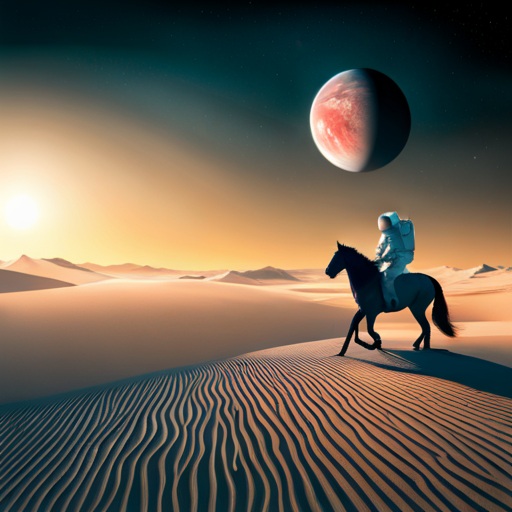

In [8]:
import base64
import io
from PIL import Image

base_64_img_str = response_body.get("artifacts")[0].get("base64")
image = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image

## Next steps

In this notebook we showed some basic examples of invoking Amazon Bedrock models using the AWS Python SDK. You're now ready to explore the other labs to dive deeper on different use-cases and patterns.